This should have happened before:
```
muniphot *.fit
munimatch --verbose frame001.pht frame*.pht
munifind -a 2 found.txt match*
```

In [1]:
# CONFIG

basedir = './inputfiles/WWCrA/'

In [2]:
# Set the WCS information manually by setting properties of the WCS
# object.

from __future__ import division, print_function

import numpy
from astropy import wcs
from astropy.io import fits

# Create a new WCS object.  The number of axes must be set
# from the start
w = wcs.WCS(naxis=2)

# Set up an "Airy's zenithal" projection
# Vector properties may be set with Python lists, or Numpy arrays
w.wcs.crpix = [1365/2.0, 1365/2.0]
w.wcs.cdelt = numpy.array([-0.000572222222222, 0.000572222222222])
w.wcs.crval = [18.0936111, -43.8325000]
w.wcs.ctype = ["RA---AIR", "DEC--AIR"]

# Some pixel coordinates of interest.
pixcrd = numpy.array([[0, 0], [1365/2.0, 1365/2.0], [45, 98]], numpy.float_)

# Convert pixel coordinates to world coordinates
world = w.wcs_pix2world(pixcrd, 1)
print(world)

# Convert the same coordinates back to pixel coordinates.
pixcrd2 = w.wcs_world2pix(world, 1)
print(pixcrd2)

# These should be the same as the original pixel coordinates, modulo
# some floating-point error.
assert numpy.max(numpy.abs(pixcrd - pixcrd2)) < 1e-6

# Now, write out the WCS object as a FITS header
header = w.to_header()

# header is an astropy.io.fits.Header object.  We can use it to create a new
# PrimaryHDU and write it to a file.
hdu = fits.PrimaryHDU(header=header)
# Save to FITS file
# hdu.writeto('test.fits')

[[ 18.63856748 -44.22175161]
 [ 18.0936111  -43.8325    ]
 [ 18.60215434 -44.16583993]]
[[ -4.76461537e-10  -4.68389771e-10]
 [  6.82500000e+02   6.82500000e+02]
 [  4.50000000e+01   9.80000000e+01]]


In [28]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

df = pd.read_csv(basedir+'found.txt', skiprows=[1], sep=' ')
df.rename(columns = {'INDEX':'STAR'}, inplace = True)
print(df.head())
print("max goodpoints:", df['GOODPOINTS'].max())
print("min stdev:", df['STDEV'].min())
#df.iloc[40]
print(df['STDEV'].sort_values().head())


   STAR  MEAN_MAG    STDEV  GOODPOINTS
0     1  -0.78516  0.04235          81
1  6384  -0.44303  0.01060          58
2  6404  -0.25691  0.01308          59
3     3  -0.09611  0.00957          76
4     2  -0.09037  0.00847          81
max goodpoints: 81
min stdev: 0.0052
40     0.00520
85     0.00533
51     0.00537
143    0.00564
27     0.00565
Name: STDEV, dtype: float64


In [29]:
def getBestComparisonStars():
    result = []
    lowest_stdev = df.sort_values('STDEV')
#    print(lowest_stdev.describe())
    for entry in range(0,10):
        #print(lowest_stdev.iloc[[entry]].index[0])
        #print(lowest_stdev.iloc[[entry]].values[0])
        print(lowest_stdev.iloc[[entry]])
        result.append((lowest_stdev.iloc[[entry]].index[0], lowest_stdev.iloc[[entry]]['GOODPOINTS']))
    return result
        
    
bestcomps = getBestComparisonStars()
#print(bestcomps)
    
    

    STAR  MEAN_MAG   STDEV  GOODPOINTS
40    49   1.78433  0.0052          81
    STAR  MEAN_MAG    STDEV  GOODPOINTS
85    98   2.46666  0.00533          81
    STAR  MEAN_MAG    STDEV  GOODPOINTS
51    61   1.97602  0.00537          80
     STAR  MEAN_MAG    STDEV  GOODPOINTS
143   166    3.0315  0.00564          77
    STAR  MEAN_MAG    STDEV  GOODPOINTS
27    36   1.65312  0.00565          81
     STAR  MEAN_MAG    STDEV  GOODPOINTS
119   139   2.82141  0.00567          81
     STAR  MEAN_MAG    STDEV  GOODPOINTS
117   132   2.78903  0.00572          80
    STAR  MEAN_MAG    STDEV  GOODPOINTS
19    26   1.53679  0.00582          81
     STAR  MEAN_MAG    STDEV  GOODPOINTS
110   123   2.73681  0.00601          80
    STAR  MEAN_MAG    STDEV  GOODPOINTS
21    27   1.56035  0.00602          81


index 2675 is <pandas.core.indexing._iLocIndexer object at 0x7f46424695c0>
              STAR     MEAN_MAG        STDEV   GOODPOINTS
count  3598.000000  3598.000000  3598.000000  3598.000000
mean   2170.777932     5.321947     0.059607    70.011117
std    1317.759731     1.068964     0.039416     9.703465
min       1.000000    -0.785160     0.005200    47.000000
25%    1039.250000     4.793297     0.028405    64.000000
50%    2127.500000     5.604265     0.053410    73.000000
75%    3225.500000     6.102333     0.083410    78.000000
max    6404.000000     6.877220     0.393700    81.000000


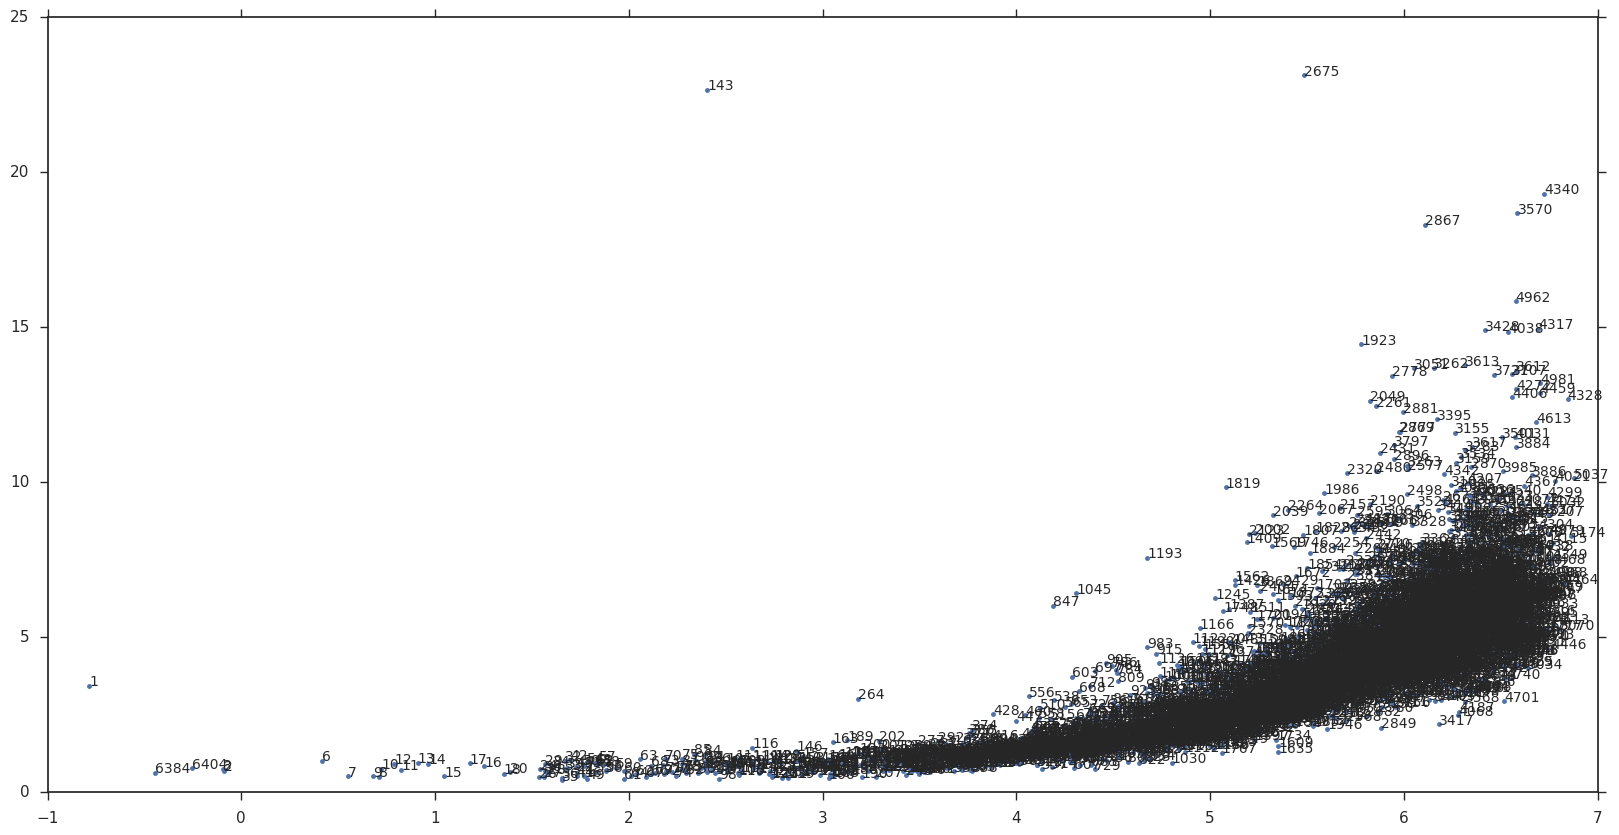

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
x = df['MEAN_MAG']
y = df['STDEV']
z = df['GOODPOINTS']
realx = x
realy = y*z
ax.plot(realx, realy, '.')
for i, d in enumerate(x):
    ax.annotate(df['STAR'][i], (realx[i],realy[i]))
print('index 2675 is', df.iloc(2675))
print(df.describe())


In [21]:
print(df['INDEX'][143])

166


In [22]:
import subprocess
# munilist -a 2 --object 143 -v 143 -c 40 143.txt match*.pht

def write_lightcurve_and_pos(checkstar, star_list, aperture, lightcurve_dir):
    !mkdir {lightcurve_dir}
    for star in star_list:
        #import os
        #print(os.environ)
        !munilist -a {str(aperture)} --object {str(star)} -v {str(star)} -c {str(checkstar)} {lightcurve_dir + str(star) + ".txt"} {basedir+'match*.pht'}
        !munilist -a {str(aperture)} --track-list {str(star)} -v {str(star)} {lightcurve_dir + "pos_" + str(star) + ".txt"} {basedir+'match*.pht'}

star_list = (143,264,2675,1045,847,1193)
lightcurve_dir = basedir + "outstars/"
write_lightcurve_and_pos(40, star_list, 2, lightcurve_dir)

mkdir: cannot create directory ‘./inputfiles/WWCrA/outstars/’: File exists
munilist (cmunipack) version 2.1.14

./inputfiles/WWCrA/match001.pht
./inputfiles/WWCrA/match002.pht
./inputfiles/WWCrA/match003.pht
./inputfiles/WWCrA/match004.pht
./inputfiles/WWCrA/match005.pht
./inputfiles/WWCrA/match006.pht
./inputfiles/WWCrA/match007.pht
./inputfiles/WWCrA/match008.pht
./inputfiles/WWCrA/match009.pht
./inputfiles/WWCrA/match010.pht
./inputfiles/WWCrA/match011.pht
./inputfiles/WWCrA/match012.pht
./inputfiles/WWCrA/match013.pht
./inputfiles/WWCrA/match014.pht
./inputfiles/WWCrA/match015.pht
./inputfiles/WWCrA/match016.pht
./inputfiles/WWCrA/match017.pht
./inputfiles/WWCrA/match018.pht
./inputfiles/WWCrA/match019.pht
./inputfiles/WWCrA/match020.pht
./inputfiles/WWCrA/match021.pht
./inputfiles/WWCrA/match022.pht
./inputfiles/WWCrA/match023.pht
./inputfiles/WWCrA/match024.pht
./inputfiles/WWCrA/match025.pht
./inputfiles/WWCrA/match026.pht
./inputfiles/WWCrA/match027.pht
./inputfiles/WWCrA/match

In [23]:
df2 = pd.read_csv(lightcurve_dir + '2675.txt', skiprows=[1], sep=' ')
df2 = df2[df2['V-C'] < 99]
print(df2['V-C'].std())
print(df2.head())
print(df2.describe())

0.309140920467
             JD      V-C       s1         V       s2         C       s3
0  2.457631e+06  4.14542  0.10845  17.40188  0.10836  13.25646  0.00429
1  2.457631e+06  4.12127  0.10513  17.39311  0.10504  13.27184  0.00435
2  2.457631e+06  4.13699  0.11121  17.41780  0.11113  13.28080  0.00433
3  2.457631e+06  4.08027  0.10915  17.35151  0.10906  13.27124  0.00439
4  2.457631e+06  4.15201  0.11451  17.46770  0.11442  13.31569  0.00456
                 JD        V-C         s1          V         s2          C  \
count  3.400000e+01  34.000000  34.000000  34.000000  34.000000  34.000000   
mean   2.457631e+06   3.872527   0.093758  17.194057   0.093648  13.321531   
std    3.498486e-02   0.309141   0.022841   0.282965   0.022871   0.044103   
min    2.457631e+06   3.280370   0.055360  16.648570   0.055180  13.256460   
25%    2.457631e+06   3.594820   0.070060  16.938353   0.069908  13.297738   
50%    2.457631e+06   3.979840   0.100925  17.298550   0.100830  13.310050   
75%    

[[ 18.63856748 -44.22175161]]


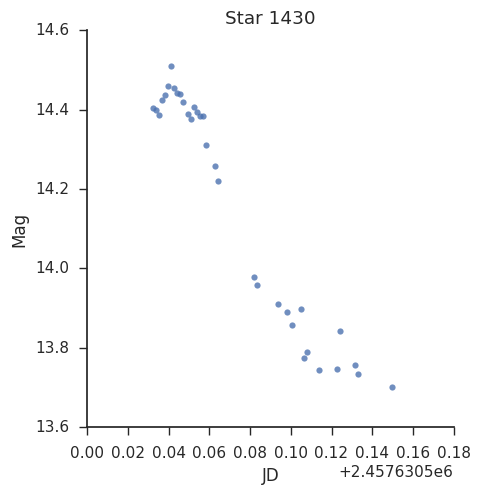

[[ 18.63856748 -44.22175161]]


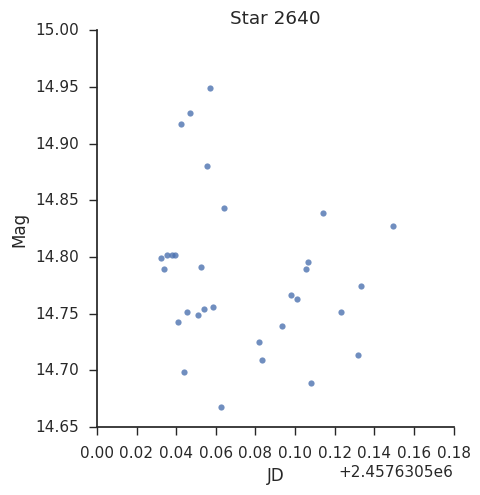

[[ 18.63856748 -44.22175161]]


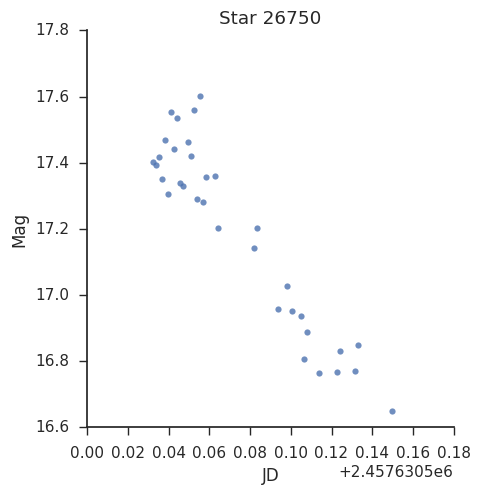

[[ 18.63856748 -44.22175161]]


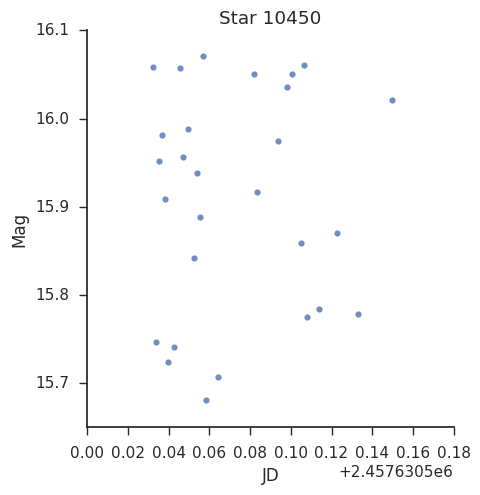

[[ 18.63856748 -44.22175161]]


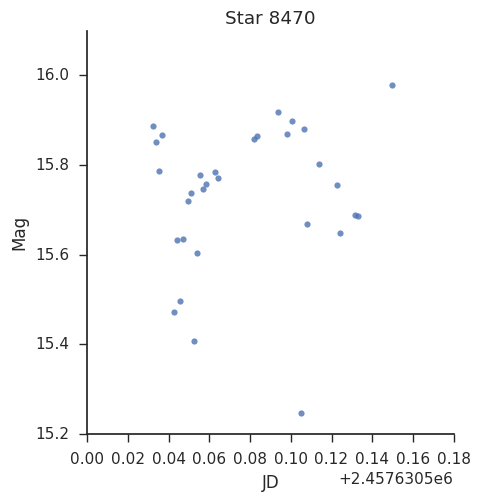

[[ 18.63856748 -44.22175161]]


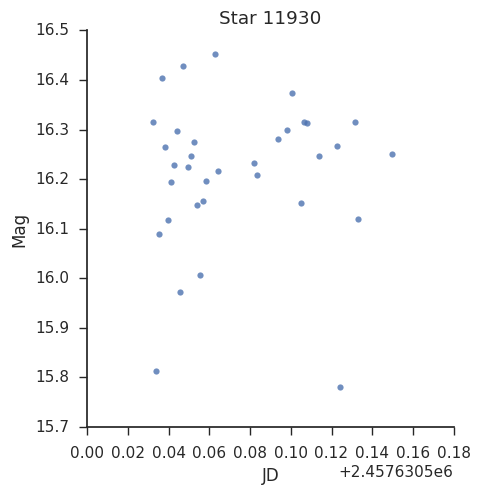

In [24]:
import seaborn as sns

def set_seaborn_style():
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("ticks")

def read_lightcurve(star):
    df2 = pd.read_csv(lightcurve_dir + str(star) + '.txt', skiprows=[1], sep=' ')
    df2 = df2[df2['V-C'] < 99]
    return df2

def read_pixel_positions(star):
    df2 = pd.read_csv(lightcurve_dir + str(star) + '.txt', skiprows=[1], sep=' ')
    df2 = df2[df2['V-C'] < 99]
    return df2

def get_radec():
    # Some pixel coordinates of interest.
    pixcrd = numpy.array([[0, 0]], numpy.float_)

    # Convert pixel coordinates to world coordinates
    world = w.wcs_pix2world(pixcrd, 1)
    print(world)
    return 0

def plot_lightcurve2(df2, name):
    g = sns.lmplot('JD', 'V', 
               data=df2, 
               fit_reg=False)
    plt.title('Star '+ str(name) + str(get_radec()))
    plt.xlabel('JD')
    plt.ylabel('Mag')    
    sns.plt.show()
    g.savefig(lightcurve_dir+str(star))
    
def plot_lightcurve(df2, name):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    x = df2['JD']
    y = df2['V']
    realx = x
    realy = y
    ax.plot(realx, realy, '.')

    fig.savefig(lightcurve_dir+str(star))
    
set_seaborn_style()
for star in star_list:
    plot_lightcurve2(read_lightcurve(star), star)

In [ ]:
from sklearn import preprocessing
df2_f = df2.loc[df['V-C'] < 90] 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df2_f['JD'])
fig = plt.figure()
ax = fig.add_subplot(111)
x = x_scaled
y = df2_f['V-C']
ax.plot(x, y, '.')


In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()